### on kansas

In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vtk_rw import read_vtk
import seaborn as sns
from plotting import plot_surf_stat_map
import matplotlib

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [7]:
from graphs import graph_from_mesh, dijkstra, shortest_path

In [3]:
sub='BP4T'

In [4]:
simple_v, simple_f, _ = read_vtk('/scr/ilz3/myelinconnect/groupavg/indv_space/%s/lowres_rh_d_def.vtk'%sub)

In [5]:
complex_v, complex_f, _ = read_vtk('/scr/ilz3/myelinconnect/struct/surf_rh/orig/mid_surface/%s_rh_mid.vtk'%sub)

In [6]:
mapping_ideal = np.load('/scr/ilz3/myelinconnect/all_data_on_simple_surf/seeds_ideal/%s_rh_highres2lowres_seeds.npy'%sub)

In [12]:
voronoi_seed_idx = mapping_ideal

In [83]:
simple_graph=graph_from_mesh(simple_v, simple_f, edge_length=True)

In [84]:
complex_graph=graph_from_mesh(complex_v, complex_f, edge_length=True)

In [21]:
df = pd.DataFrame(columns=['simple e0', 'simple e1', 'simple len', 
                           'complex e0', 'complex e1', 'complex len'],
                 index=np.arange(len(simple_graph.edges())))


import time
start = time.time()

count = 0
for e in simple_graph.edges_iter():

    df['simple e0'][count] = e[0]
    df['simple e1'][count] = e[1]
    df['simple len'][count] = simple_graph[e[0]][e[1]]

    df['complex e0'][count] = voronoi_seed_idx[e[0]]
    df['complex e1'][count] = voronoi_seed_idx[e[1]]
    
    try: 
        dist, _ = dijkstra(complex_graph, start=voronoi_seed_idx[e[0]], end=voronoi_seed_idx[e[1]])
        df['complex len'][count] = dist[voronoi_seed_idx[e[1]]]
    except KeyError:
        df['complex len'][count] = np.nan

    count += 1
    
end = time.time()
print (end-start), 'sec'

In [82]:
df.to_csv('/scr/ilz3/myelinconnect/all_data_on_simple_surf/BP4T_rh_euclid_paths.csv')

In [247]:
differences = dict()
for idx in voronoi_seed_idx:
    rows = np.concatenate((np.where(df['complex e0']==idx)[0],np.where(df['complex e1']==idx)[0]))
    differences[idx] = list(df['complex len'][rows] - df['simple len'][rows])

In [251]:
diff_df = pd.DataFrame(columns=['mean', 'max', 'sdv', 'nan'],
                       index=voronoi_seed_idx)
for idx in voronoi_seed_idx:
    diff_df['mean'][idx] = np.nanmean(differences[idx])
    diff_df['max'][idx] = np.nanmax(differences[idx])
    diff_df['sdv'][idx] = np.nanstd(differences[idx])
    diff_df['nan'][idx] = np.where(np.isnan(differences[idx]))[0].shape[0]

In [252]:
sns.set_context('notebook', font_scale=1.5)

In [274]:
np.where(diff_df['nan']>0)[0].shape

(535,)

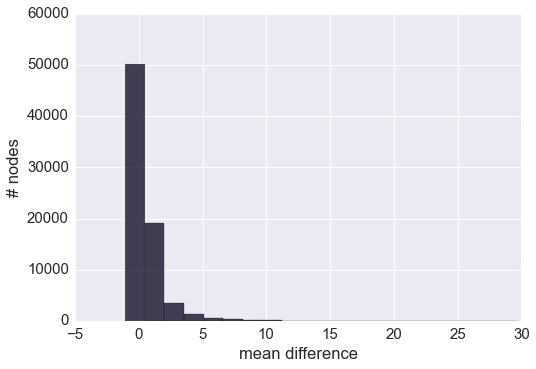

In [256]:
plt.hist(np.asarray(diff_df['mean']), bins=20, color=pal[0], alpha=0.8);
plt.xlabel('mean difference')
plt.ylabel('# nodes')

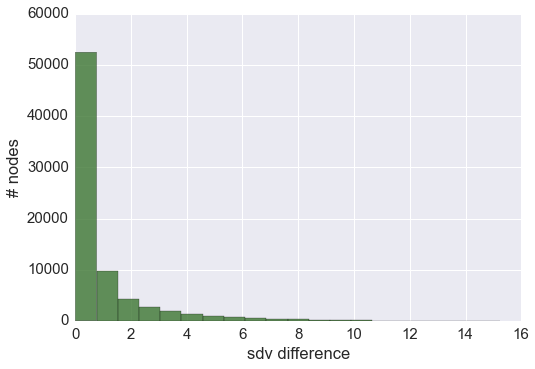

In [257]:
plt.hist(np.asarray(diff_df['sdv']), bins=20, color=pal[3], alpha=0.8);
plt.xlabel('sdv difference')
plt.ylabel('# nodes')

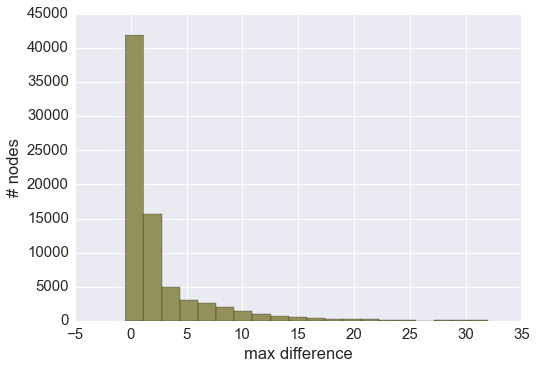

In [258]:
plt.hist(np.asarray(diff_df['max']), bins=20, color=pal[4], alpha=0.8);
plt.xlabel('max difference')
plt.ylabel('# nodes')

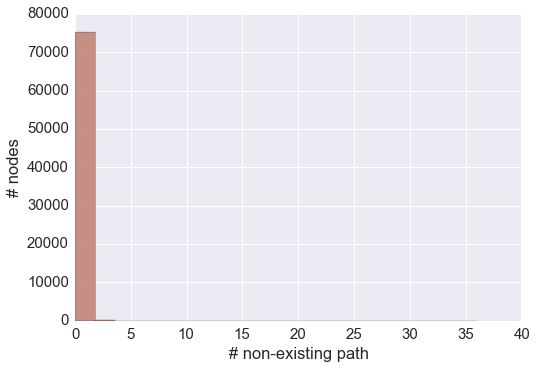

In [259]:
plt.hist(np.asarray(diff_df['nan']), bins=20, color=pal[5], alpha=0.8);
plt.xlabel('# non-existing path')
plt.ylabel('# nodes')

In [260]:
pal=sns.color_palette('cubehelix', 10)

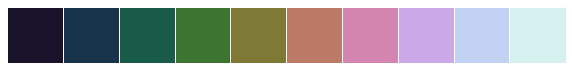

In [261]:
sns.palplot(pal)

In [275]:
max_outlier = np.where(diff_df['max']>5)[0]

In [276]:
mean_outlier = np.where(diff_df['mean']>2)[0]

In [277]:
sdv_outlier = np.where(diff_df['sdv']>2)[0]

In [278]:
nan_outlier = np.where(diff_df['nan']>1)[0]

In [279]:
print 'max', 'mean'
print 'total', np.concatenate((max_outlier, mean_outlier)).shape[0]
print 'unique', np.unique(np.concatenate((max_outlier, mean_outlier))).shape[0]
print 'overlap', np.concatenate((max_outlier, mean_outlier)).shape[0] - np.unique(np.concatenate((max_outlier, mean_outlier))).shape[0]
print '% overlap', (np.concatenate((max_outlier, mean_outlier)).shape[0] - np.unique(np.concatenate((max_outlier, mean_outlier))).shape[0])/np.concatenate((max_outlier, mean_outlier)).shape[0]


max mean
total 18049
unique 12288
overlap 5761
% overlap 0.319186658541


In [280]:
print 'max', 'sdv'
print 'total', np.concatenate((max_outlier, sdv_outlier)).shape[0]
print 'unique', np.unique(np.concatenate((max_outlier, sdv_outlier))).shape[0]
print 'overlap', np.concatenate((max_outlier, sdv_outlier)).shape[0] - np.unique(np.concatenate((max_outlier, sdv_outlier))).shape[0]
print '% overlap', (np.concatenate((max_outlier, sdv_outlier)).shape[0] - np.unique(np.concatenate((max_outlier, sdv_outlier))).shape[0])/np.concatenate((max_outlier, mean_outlier)).shape[0]


max sdv
total 22349
unique 12126
overlap 10223
% overlap 0.56640257078


In [281]:
print 'mean', 'sdv'
print 'total', np.concatenate((mean_outlier, sdv_outlier)).shape[0]
print 'unique', np.unique(np.concatenate((mean_outlier, sdv_outlier))).shape[0]
print 'overlap', np.concatenate((mean_outlier, sdv_outlier)).shape[0] - np.unique(np.concatenate((mean_outlier, sdv_outlier))).shape[0]
print '% overlap', (np.concatenate((mean_outlier, sdv_outlier)).shape[0] - np.unique(np.concatenate((mean_outlier, sdv_outlier))).shape[0])/np.concatenate((mean_outlier, sdv_outlier)).shape[0]


mean sdv
total 16878
unique 11204
overlap 5674
% overlap 0.336177272189


In [282]:
print 'mean', 'nan'
print 'total', np.concatenate((mean_outlier, nan_outlier)).shape[0]
print 'unique', np.unique(np.concatenate((mean_outlier, nan_outlier))).shape[0]
print 'overlap', np.concatenate((mean_outlier, nan_outlier)).shape[0] - np.unique(np.concatenate((mean_outlier, nan_outlier))).shape[0]
print '% overlap', (np.concatenate((mean_outlier, nan_outlier)).shape[0] - np.unique(np.concatenate((mean_outlier, nan_outlier))).shape[0])/np.concatenate((mean_outlier, nan_outlier)).shape[0]


mean nan
total 6633
unique 6633
overlap 0
% overlap 0.0


In [283]:
print 'max', 'nan'
print 'total', np.concatenate((max_outlier, nan_outlier)).shape[0]
print 'unique', np.unique(np.concatenate((max_outlier, nan_outlier))).shape[0]
print 'overlap', np.concatenate((max_outlier, nan_outlier)).shape[0] - np.unique(np.concatenate((max_outlier, nan_outlier))).shape[0]
print '% overlap', (np.concatenate((max_outlier, nan_outlier)).shape[0] - np.unique(np.concatenate((max_outlier, nan_outlier))).shape[0])/np.concatenate((max_outlier, nan_outlier)).shape[0]


max nan
total 12104
unique 12082
overlap 22
% overlap 0.00181758096497


In [284]:
print 'sdv', 'nan'
print 'total', np.concatenate((sdv_outlier, nan_outlier)).shape[0]
print 'unique', np.unique(np.concatenate((sdv_outlier, nan_outlier))).shape[0]
print 'overlap', np.concatenate((sdv_outlier, nan_outlier)).shape[0] - np.unique(np.concatenate((sdv_outlier, nan_outlier))).shape[0]
print '% overlap', (np.concatenate((sdv_outlier, nan_outlier)).shape[0] - np.unique(np.concatenate((sdv_outlier, nan_outlier))).shape[0])/np.concatenate((sdv_outlier, nan_outlier)).shape[0]


sdv nan
total 10933
unique 10914
overlap 19
% overlap 0.00173785786152
